In [ ]:
# %pip install numpy matplotlib oasis-deconv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oasis.functions import deconvolve

c:\Users\sange\anaconda3\envs\s2p\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [11]:
traces = np.load("data/F.npy")
cal_traces = []
dtraces = []

for i, trace in enumerate(traces):
    F = trace.copy()
    F0 = np.median(F)
    cal_trace = (F - F0) / abs(F0)
    try:
        _, dt, _, _, _ = deconvolve(cal_trace)
        cal_traces.append(cal_trace)
        dtraces.append(dt)
    except:
        continue

C:\Users\sange\AppData\Local\Temp\ipykernel_18424\3552383840.py:8: RuntimeWarning: invalid value encountered in divide
  cal_trace = (F - F0) / abs(F0)


In [37]:
ind = 11
trace = cal_traces[ind].copy()
dtrace = dtraces[ind].copy()

In [72]:
trace1 = cal_traces[25].copy()
dtrace1 = dtraces[25].copy()

trace2 = cal_traces[5].copy()
dtrace2 = dtraces[5].copy()

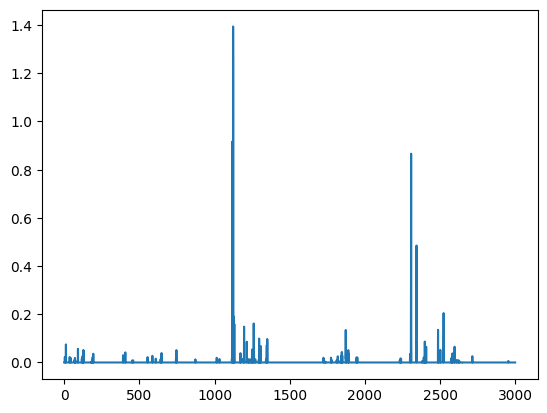

In [75]:
plt.plot(dtrace2)

# Thresholding and Events: Converting Continuous Calcium Traces into Discrete Event Times

In this module, we will analyze the deconvolved output of calcium imaging data to extract discrete neural events. The deconvolved signal, inferred using the OASIS algorithm, provides a continuous estimate of spiking activity over time. However, this signal includes small amplitude fluctuations that may not reflect actual spikes. To interpret this signal meaningfully, we must detect and extract the time points at which neurons were most likely active. This notebook guides you through this process, starting with thresholding the deconvolved signal, identifying event onsets, and ending with the computation of firing rate traces.


## Understanding and Thresholding the Deconvolved Signal

The deconvolved signal returned by OASIS is sparse but continuous. While many values are close to zero, not all non-zero points correspond to real spike events. In this section, we will inspect the deconvolved traces from selected neurons and apply amplitude thresholding to isolate frames with significant spiking activity. This step filters out low-amplitude noise and prepares the signal for event detection.

When thresholding the deconvolved signal, your goal is to keep sharp, isolated peaks while ignoring small background fluctuations. 

To begin, we try a simple manual threshold. This helps us visually check which parts of the deconvolved trace are above a chosen cutoff. We are not detecting events yet. We are just seeing where the signal exceeds a fixed value.

**Example** Plot the deconvolved trace. Add a line at 0.15.

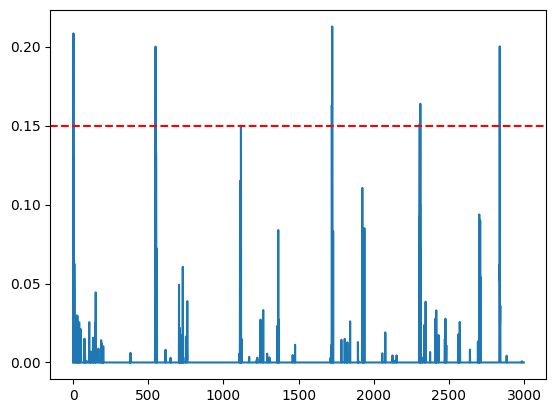

In [41]:
plt.plot(dtrace)
plt.axhline(0.15, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.0001.

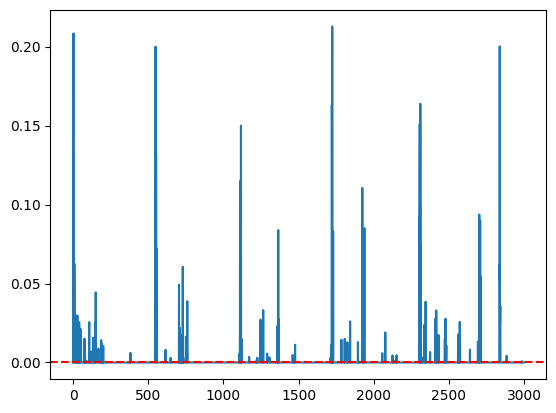

In [42]:
plt.plot(dtrace)
plt.axhline(0.0001, color='r', linestyle='--');

Plot the deconvolved trace. Set y-axis to (0, 0.01). Add a line at 0.00001.

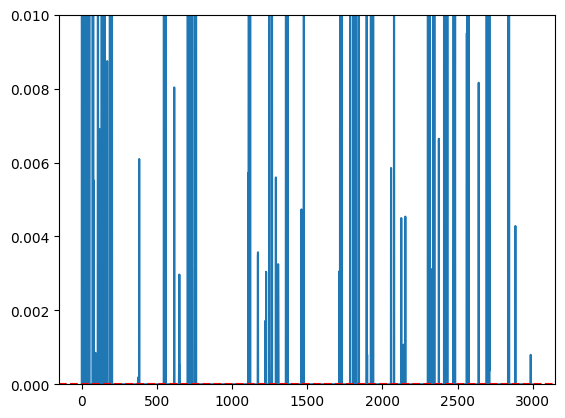

In [47]:
plt.plot(dtrace)
plt.ylim(0.00, 0.01)
plt.axhline(0.00001, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.002.

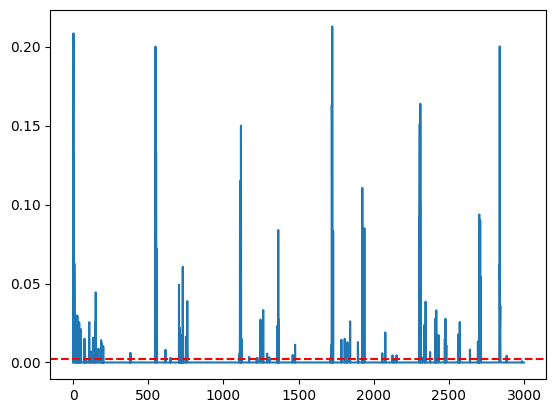

In [49]:
plt.plot(dtrace)
plt.axhline(0.002, color='r', linestyle='--');

Now we apply the threshold to the deconvolved signal and count how many frames are above it. This gives us a rough idea of how active the neuron appears, based on the chosen threshold.

**Example** Set threshold to 0.15. Count how many values in the deconvolved trace are above this threshold.

In [50]:
np.sum(dtrace > 0.15)

np.int64(7)

Set threshold to 0.002. Count how many values are above this threshold.

In [51]:
np.sum(dtrace > 0.002)

np.int64(137)

Set threshold to 0.00001. Count how many values are above this threshold.

In [52]:
np.sum(dtrace > 0.00001)

np.int64(160)

Instead of choosing a threshold manually, we can use a data-driven rule: mean + 2 × standard deviation. This sets the threshold relative to the baseline and variability in the signal. We then count how many frames exceed this automatic threshold.

Automatic thresholds depend on both the baseline (mean or median) and the spread (standard deviation) of the deconvolved signal. By trying different combinations, we can begin to choose thresholds that are sensitive to strong activity, while ignoring low-level noise.

**Example** Set threshold to mean + 10 × std. Count how many values are above this threshold.

In [53]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 10 * sigma
np.sum(dtrace > auto_thresh)

np.int64(9)

Set threshold to mean + 5 × std. Count how many values are above this threshold.

In [59]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 5 * sigma
np.sum(dtrace > auto_thresh)

np.int64(31)

Set threshold to median + 2 × std. Count how many values are above this threshold.

In [58]:
mu = np.median(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 2.0 * sigma
np.sum(dtrace > auto_thresh)

np.int64(57)


## Identifying Spike Times from Thresholded Signal

After applying a threshold to the deconvolved signal, we are left with a list of frames where the signal is high. However, these high values often span several consecutive frames for a single spike event. Instead of treating every suprathreshold frame as a separate spike, we want to detect only the onset of each event — the frame where the activity first crosses the threshold. This gives us a cleaner, more biologically meaningful list of spike times. To do this, we will follow three steps:

- Convert the thresholded signal into a binary (0 or 1) vector
- `Use np.diff()` to detect where the signal changes from 0 to 1
- Convert those indices to timestamps using the frame rate

We start by converting the deconvolved trace into a binary vector using a threshold. This shows us where spikes might be present (1) and where there is no activity (0). We plot both the original deconvolved signal and the binary spike vector together.

**Example** Threshold the deconvolved trace at 0.02 plot both the trace and the binary vector.

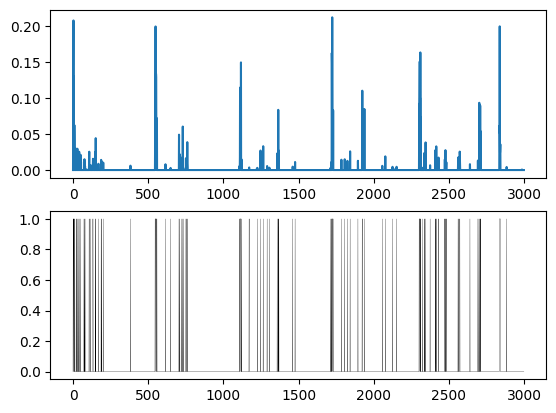

In [255]:
binary = dtrace > 0.002

plt.subplot(211)
plt.plot(dtrace)

plt.subplot(212)
plt.plot(binary, color='black', linewidth=0.2)

Threshold the deconvolved trace1 at 0.2 plot both the trace and the binary vector.

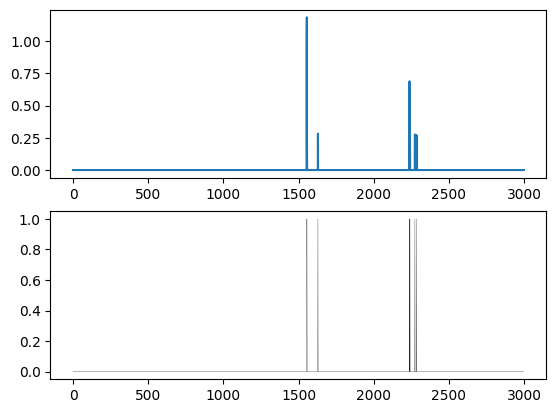

In [256]:
binary1 = dtrace1 > 0.2

plt.subplot(211)
plt.plot(dtrace1)

plt.subplot(212)
plt.plot(binary1, color='black', linewidth=0.2)

Threshold the deconvolved trace2 at 0.002 and plot both the trace and the binary vector.

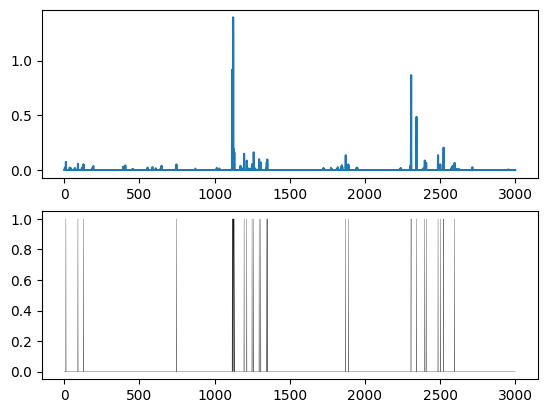

In [257]:
binary2 = dtrace2 > 0.05

plt.subplot(211)
plt.plot(dtrace2)

plt.subplot(212)
plt.plot(binary2, color='black', linewidth=0.2)

To find the start of each spike event, we look for where the binary vector changes from 0 to 1. These transitions mark the onset of activity. We use `np.diff()` to compute the difference between consecutive frames and then look for values equal to 1.

**Example** How many spike onsets in trace?

In [258]:
diff = np.diff(binary.astype(int))
onsets = np.where(diff == 1)[0] + 1
np.sum(binary), len(onsets)

(np.int64(137), 95)

How many spike onsets in trace1?

In [259]:
diff = np.diff(binary1.astype(int))
onsets1 = np.where(diff == 1)[0] + 1
np.sum(binary1), len(onsets1)

(np.int64(9), 6)

How many spike onsets in trace2?

In [260]:
diff = np.diff(binary2.astype(int))
onsets2 = np.where(diff == 1)[0] + 1
np.sum(binary2), len(onsets2)

(np.int64(36), 26)

The spike onset indices give us the frame number of each event. To convert these to spike times in seconds, we multiply the indices by the frame interval `dt`. If the frame rate is 30 Hz, then `dt = 1 / 30`.

**Example** Convert the onset indices (trace) to spike times (Frame Rate = 30 Hz).


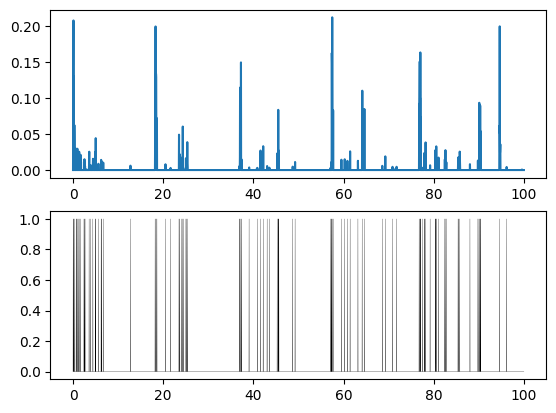

In [261]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
spike_times = np.zeros_like(t)
spike_times[onsets] = 1

plt.subplot(211)
plt.plot(t, dtrace)

plt.subplot(212)
plt.plot(t, spike_times, color='black', linewidth=0.2)

Convert the onset indices (trace1) to spike times

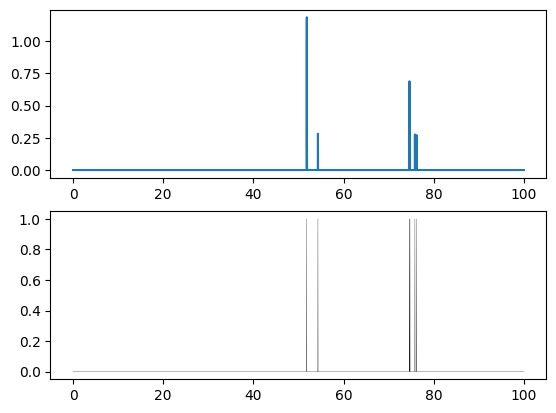

In [262]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
spike_times1 = np.zeros_like(t)
spike_times1[onsets1] = 1

plt.subplot(211)
plt.plot(t, dtrace1)

plt.subplot(212)
plt.plot(t, spike_times1, color='black', linewidth=0.2)


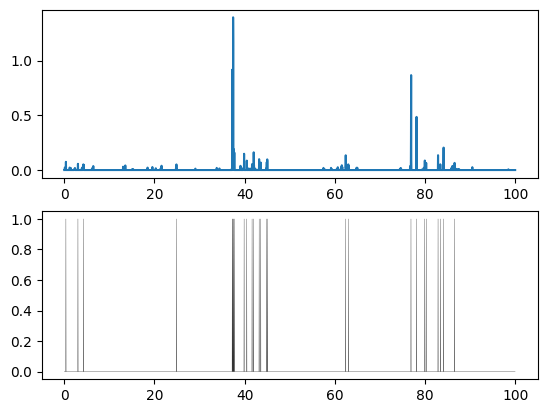

In [263]:
dt = 1 / 30

t = np.arange(len(dtrace)) * dt
spike_times2 = np.zeros_like(t)
spike_times2[onsets2] = 1

plt.subplot(211)
plt.plot(t, dtrace2)

plt.subplot(212)
plt.plot(t, spike_times2, color='black', linewidth=0.2)

## Visualizing Spike Events on Top of the Deconvolved Trace

Once spike times have been extracted, we overlay them on the deconvolved calcium trace as short vertical ticks. This visualization provides a qualitative check on how well detected events correspond to rapid fluorescence transients, which are proxies for neuronal action potentials. Since calcium indicators report neural activity indirectly and with temporal smoothing, overlaying inferred spike times helps assess the precision of event detection methods. It also enables a visual comparison between neural dynamics and spike timing, revealing cases where the thresholding may have missed subtle transients or falsely captured noise. This step is particularly useful when screening multiple neurons for signal quality or validating preprocessing parameters.

**Example** Plot the deconvolved trace. Add vertical lines at the spike times.

Text(0, 0.5, 'Relative Fluorescence Change [ΔF/F₀]')

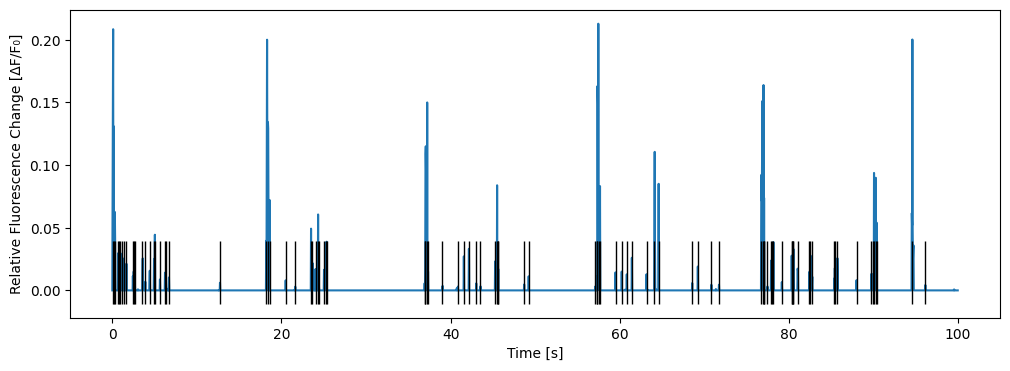

In [264]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
tick_y = np.min(dtrace) - 0.05 * (np.max(dtrace) - np.min(dtrace))
spike_event_times = t[spike_times == 1]

plt.figure(figsize=(12, 4))
plt.plot(t, dtrace)

plt.vlines(spike_event_times, ymin=tick_y, ymax=tick_y + 0.05, color='black', linewidth=1.)
plt.xlabel("Time [s]")
plt.ylabel("Relative Fluorescence Change [ΔF/F₀]")

Plot the deconvolved trace1. Add vertical lines at the spike times.

Text(0, 0.5, 'Relative Fluorescence Change [ΔF/F₀]')

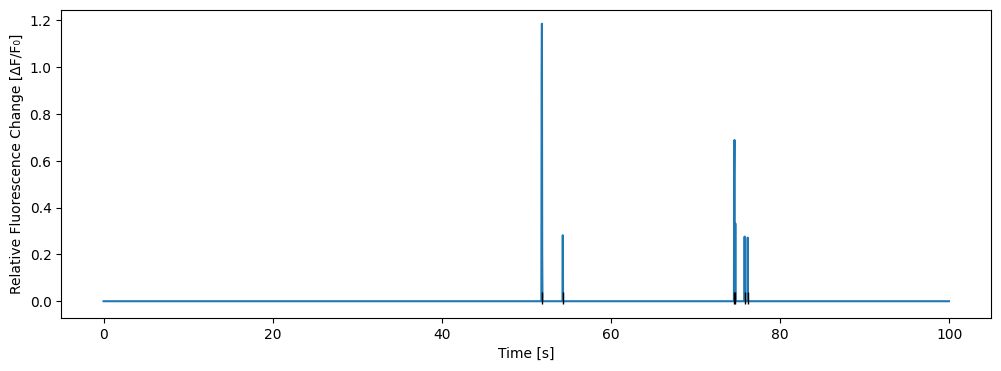

In [265]:
dt = 1 / 30
t = np.arange(len(dtrace1)) * dt
tick_y = np.min(dtrace) - 0.05 * (np.max(dtrace) - np.min(dtrace))
spike_event_times = t[spike_times1 == 1]

plt.figure(figsize=(12, 4))
plt.plot(t, dtrace1)

plt.vlines(spike_event_times, ymin=tick_y, ymax=tick_y + 0.05, color='black', linewidth=1.)
plt.xlabel("Time [s]")
plt.ylabel("Relative Fluorescence Change [ΔF/F₀]")

Plot the deconvolved trace2. Add vertical lines at the spike times.

Text(0, 0.5, 'Relative Fluorescence Change [ΔF/F₀]')

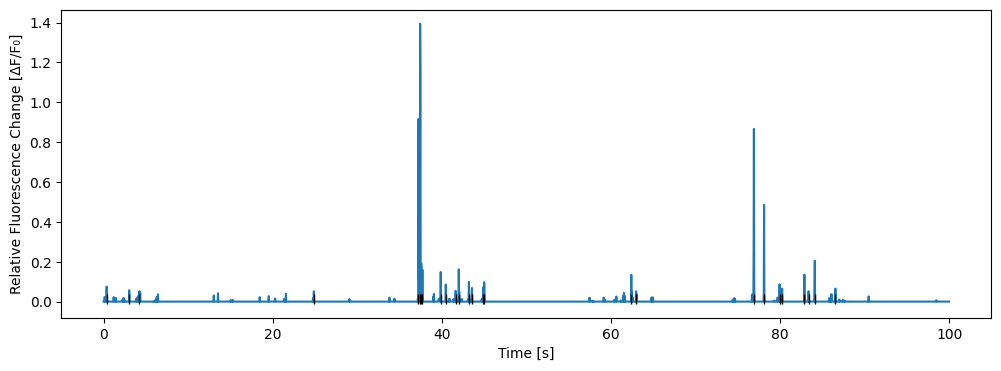

In [266]:
dt = 1 / 30
t = np.arange(len(dtrace2)) * dt
tick_y = np.min(dtrace) - 0.05 * (np.max(dtrace) - np.min(dtrace))
spike_event_times = t[spike_times2 == 1]

plt.figure(figsize=(12, 4))
plt.plot(t, dtrace2)

plt.vlines(spike_event_times, ymin=tick_y, ymax=tick_y + 0.05, color='black', linewidth=1.)
plt.xlabel("Time [s]")
plt.ylabel("Relative Fluorescence Change [ΔF/F₀]")

## Estimating Firing Rate from Extracted Spike Times

Once we have a list of spike times, we can compute a time-resolved firing rate — a summary of how frequently the neuron fires over time. This is a useful representation for analyzing temporal patterns, comparing activity across conditions, or aligning responses with stimuli. The firing rate smooths out individual spikes and helps reveal broader trends in neural activity.

We estimate the firing rate by dividing the recording into equal-sized time bins and counting how many spikes fall into each bin. These counts are then divided by the bin width to convert them into firing rate values (in Hertz).

We start by creating time bins using `np.arange()` and passing them to `np.histogram()` to count the number of spikes in each bin.

**Example** Set the bin width to 1 second and use np.histogram() to count spikes per bin (trace).

In [274]:
dt = 1 / 30
t = np.arange(len(dtrace)) * dt
T = len(dtrace) * dt
spike_event_times = t[spike_times == 1]


bins = np.arange(0, T + 1, 1.0)
counts, _ = np.histogram(spike_event_times, bins=bins);

Set the bin width to 1 second and use np.histogram() to count spikes per bin (trace1).

In [268]:
dt = 1 / 30
t = np.arange(len(dtrace1)) * dt
T = len(dtrace) * dt
spike_event_times = t[spike_times1 == 1]


bins1 = np.arange(0, T + 1, 1.0)
counts1, _ = np.histogram(spike_event_times, bins=bins);

Set the bin width to 1 second and use np.histogram() to count spikes per bin (trace2).

In [269]:
dt = 1 / 30
t = np.arange(len(dtrace2)) * dt
T = len(dtrace2) * dt
spike_event_times = t[spike_times2 == 1]


bins2 = np.arange(0, T + 1, 1.0)
counts2, _ = np.histogram(spike_event_times, bins=bins);

**Example** Compute the firing rate and plot it over time (trace).

Text(0, 0.5, 'Firing Rate [Hz]')

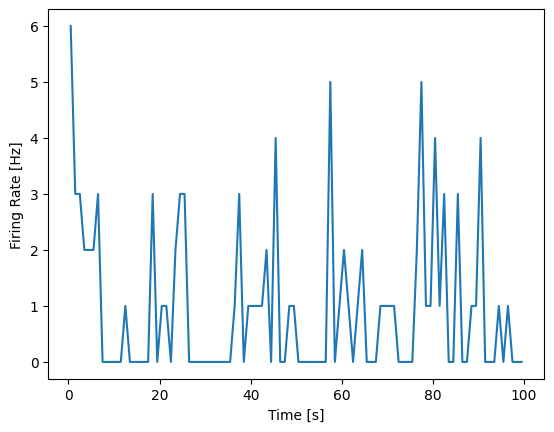

In [275]:
bin_width = 1.0
firing_rate = counts / bin_width
bin_centers = bins[:-1] + bin_width / 2

plt.plot(bin_centers, firing_rate)
plt.xlabel("Time [s]")
plt.ylabel("Firing Rate [Hz]")

Compute the firing rate and plot it over time (trace1).

Text(0, 0.5, 'Firing Rate [Hz]')

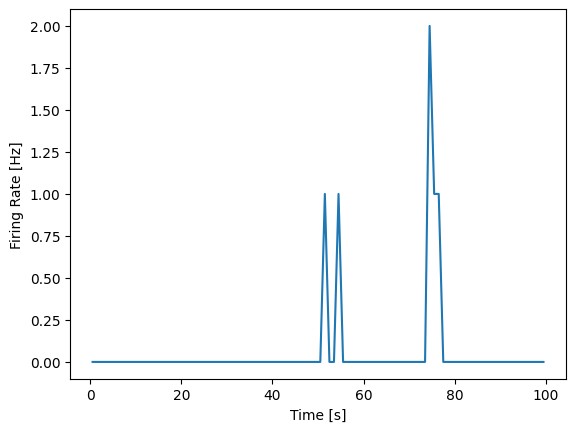

In [271]:
bin_width = 1.0
firing_rate = counts1 / bin_width
bin_centers = bins1[:-1] + bin_width / 2

plt.plot(bin_centers, firing_rate)
plt.xlabel("Time [s]")
plt.ylabel("Firing Rate [Hz]")

Compute the firing rate and plot it over time (trace2).

Text(0, 0.5, 'Firing Rate [Hz]')

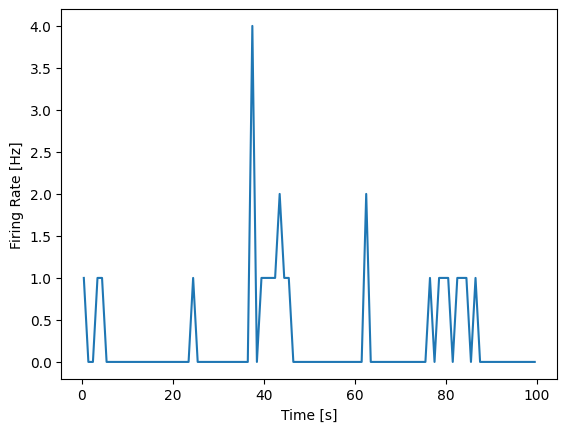

In [254]:
bin_width = 1.0
firing_rate = counts2 / bin_width
bin_centers = bins2[:-1] + bin_width / 2

plt.plot(bin_centers, firing_rate)
plt.xlabel("Time [s]")
plt.ylabel("Firing Rate [Hz]")